<a href="https://colab.research.google.com/github/RonakMehta21/FastAI-Keras-Colabs/blob/master/FastAI_Image_Collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build your Image Classification Model

This notebook shows how to build your own image classification model using your own data, including topics such as:

* Image collection
* Parallel downloading
* Creating a validation set, and
* Data cleaning, using the model to help us find data problems.

Import the necessary library

In [0]:
from fastai.vision import *

##Download the URLs

Download the CSV files containing the urls of the images by running the below JavaScript code in the Brower's console page.

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

In [0]:
folder = 'cars'
file = 'urls_cars.csv'

In [0]:
folder = 'trucks'
file = 'urls_trucks.csv'

In [0]:
folder = 'buses'
file = 'urls_buses.csv'

In [0]:
path = Path('data/automobiles')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
classes = ['cars','trucks','buses']

In [13]:
download_images(path/file, dest, max_pics=200)

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

In [14]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

cars


trucks


buses


In [15]:
path.ls()

[PosixPath('data/automobiles/urls_buses.csv'),
 PosixPath('data/automobiles/models'),
 PosixPath('data/automobiles/cars'),
 PosixPath('data/automobiles/urls_cars.csv'),
 PosixPath('data/automobiles/cleaned.csv'),
 PosixPath('data/automobiles/trucks'),
 PosixPath('data/automobiles/buses'),
 PosixPath('data/automobiles/urls_trucks.csv')]

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [17]:
data.classes

['buses', 'cars', 'trucks']

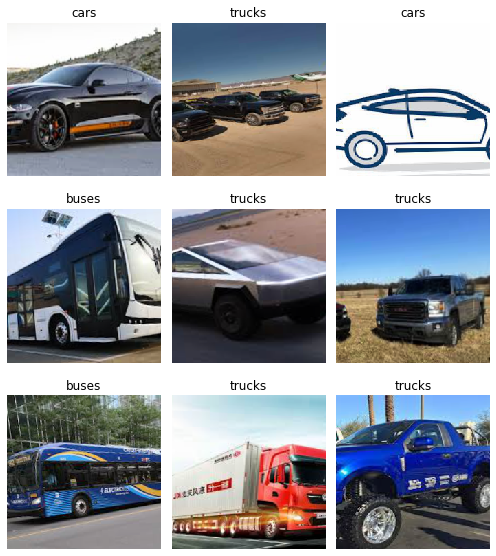

In [18]:
data.show_batch(rows=3, figsize=(7,8))

In [19]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['buses', 'cars', 'trucks'], 3, 432, 108)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [25]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.466650,0.512290,0.157407,02:20
1,0.870018,0.358297,0.083333,02:23
2,0.640800,0.362377,0.064815,02:22
3,0.545786,0.324868,0.074074,02:21


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

run learn.lr_find()

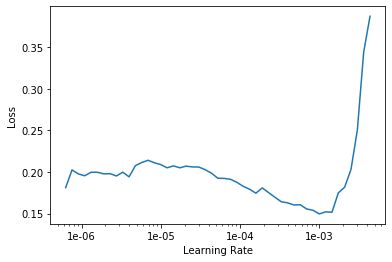

In [29]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-45))

epoch,train_loss,valid_loss,error_rate,time
0,0.256926,0.321149,0.074074,03:20
1,0.252703,0.308973,0.074074,03:24


The model gives ~74% accuracy

Save the model

In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

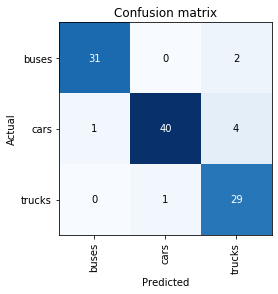

In [24]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [0]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Then we create a new learner to use our new databunch with all the images.

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [40]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [0]:
ImageCleaner(ds, idxs, path)

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [0]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [0]:
defaults.device = torch.device('cpu')

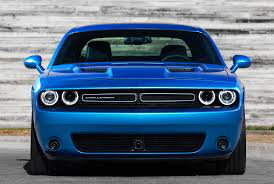

In [28]:
img = open_image(path/'cars'/'00000021.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [0]:
learn = load_learner(path)

In [33]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category cars

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)